In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Have collected our data set from Tripadvisor for hotel review through kaggle platform 

In [4]:
#loading libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns




import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import random as rn

import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

In [6]:
#load the dataset
review_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tripadvisor_hotel_reviews.csv')

In [7]:
#show dataset summary
review_df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [8]:
#checking for null values
review_df.isna().sum()

Review    0
Rating    0
dtype: int64

In [9]:
#show class distribution 
class_dist = review_df['Rating'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [10]:
ditribution_plot(x= class_dist.index, y= class_dist.values, name= 'Class Distribution')

In [11]:
#show frequently used words
def wordCloud_generator(review_df, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(review_df.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

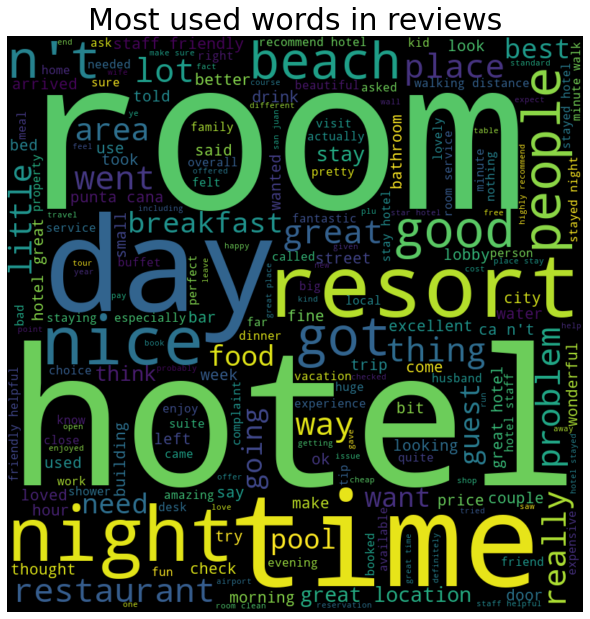

In [12]:
wordCloud_generator(review_df['Review'], title="Most used words in reviews")

In [13]:
#data processing
X = review_df['Review'].copy()
y = review_df['Rating'].copy()

In [14]:
#data cleaning
def data_cleaner(review):
    
    # remove digits
    review = re.sub(r'\d+',' ', review)
    
    #removing stop words
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])
    
    #Stemming
    #review = " ".join([ps.stem(w) for w in review])
    
    return review

ps = PorterStemmer() 
stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

In [15]:
#data tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[exp_sen]))
print("\nAfter tokenizing :\n{}".format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("\nAfter padding :\n{}".format(X[exp_sen]))

Vocabulary size: 49536
max length of sentence: 1940

Example:

Sentence:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

In [16]:
#performing encoding
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y = review_df['Rating'].copy()
y.replace(encoding, inplace=True)

In [17]:
#split data and into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=67, stratify=y
)

In [18]:
#modeling building and trainig data
# hyper parameters
EPOCHS = 3
BATCH_SIZE = 100
embedding_dim = 16
units = 76

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])

In [19]:
#compile data
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 16)           792576    
_________________________________________________________________
bidirectional (Bidirectional (None, 350, 152)          56544     
_________________________________________________________________
conv1d (Conv1D)              (None, 348, 64)           29248     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 174, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 11136)             0         
_________________________________________________________________
dropout (Dropout)            (None, 11136)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [20]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/3
121/121 - 107s - loss: 1.2622 - accuracy: 0.4507 - val_loss: 0.9895 - val_accuracy: 0.5637
Epoch 2/3
121/121 - 102s - loss: 0.9454 - accuracy: 0.5705 - val_loss: 0.9196 - val_accuracy: 0.5613
Epoch 3/3
121/121 - 103s - loss: 0.7726 - accuracy: 0.6550 - val_loss: 0.9495 - val_accuracy: 0.6007


In [21]:
#traini history
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()


In [22]:
#data Evaluation
pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [23]:
#show the accuracy
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))

Accuracy: 0.6108235989945291


In [24]:
#show the mean absolute error
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))

Accuracy: 0.6108235989945291


In [25]:
#display the root mean squaree error
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))

Accuracy: 0.6108235989945291


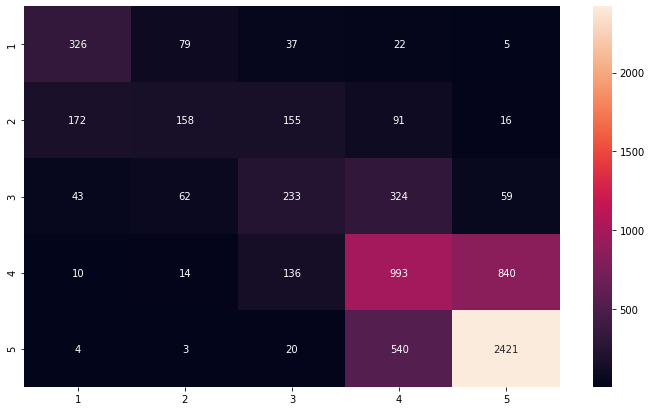

In [26]:
#Plotting the Confusion matrix
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [27]:
!pip install jupyter-dash

     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 1.0MB 23.7MB/s 
     |████████████████████████████████| 3.5MB 35.6MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 1.8MB 37.2MB/s 
     |████████████████████████████████| 358kB 43.2MB/s 
  Created wheel for dash: filename=dash-1.20.0-cp37-none-any.whl size=85845 sha256=271dbf2bfb00067317cbc6d8fa6d3ce3e4a809df4610ff52e75ca677cb7f9368
  Stored in directory: /root/.cache/pip/wheels/e6/33/41/ce361d0d1da277d2350f815b10f2ab1e331592d93ef2b07e29
  Created wheel for dash-renderer: filename=dash_renderer-1.9.1-cp37-none-any.whl size=1014873 sha256=a8dcf5dc92008d0e225c79d3c5fc02bd1d0557eb31ec84363bf74de29c3b3c34
  Stored in directory: /root/.cache/pip/wheels/03/a9/c5/dd5815c601b0ede164c223ffd7bafebde716ca57de06ef8aec
  Created wheel for dash-core-components: filename=dash_core_components-1.16.0-cp37-none-any.whl size=3540992 sha256=b2d001a409160896d7ddff

In [30]:
!pip install dash-cytoscape

     |████████████████████████████████| 3.6MB 22.7MB/s 


In [29]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as doc
import dash_html_components as html
from dash.dependencies import Input, Output

In [35]:
    from jupyter_dash import JupyterDash  # pip install dash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd  # pip install pandas
import plotly.express as px
import math
from dash import no_update


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

df = review_df

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='dpdn',
            value='breadthfirst',
            clearable=False,
            options=[
                {'label': name.capitalize(), 'value': name}
                for name in ['breadthfirst' ,'grid', 'random', 'circle', 'cose', 'concentric']
            ]
        ),
        cyto.Cytoscape(
            id='org-chart',
            autoungrabify=True,
            minZoom=0.2,
            maxZoom=1,
            layout={'name': 'breadthfirst'},
            style={'width': '100%', 'height': '500px'},
            elements=
                [
                    # Nodes elements
                    {'data': {'id': x, 'label': x}} for x in df.name
                ]
                +
                [
                    # Edge elements
                    {'data': {'source': 'Executive Director (Harriet)', 'target': 'Vice President (Sarah)'}},
                    {'data': {'source': 'Executive Director (Harriet)', 'target': 'Vice President (Charlotte)'}},
                    {'data': {'source': 'Vice President (Sarah)', 'target': 'Program Officer (Sojourner)'}},
                    {'data': {'source': 'Vice President (Sarah)', 'target': 'Program Officer (Elizabeth)'}},
                    {'data': {'source': 'Vice President (Charlotte)', 'target': 'Program Associate (Ellen)'}},
                ]
        )
    ], className='six columns'),

    html.Div([
        html.Div(id='empty-div', children='')
    ],className='one column'),

    html.Div([
        dcc.Graph(id='my-graph', figure=px.bar(df, x='name', y='slaves_freed'))
    ], className='five columns'),

], className='row')


@app.callback(Output('org-chart', 'layout'),
              Input('dpdn', 'value'))
def update_layout(layout_value):
  if layout_value == 'breadthfirst':
        return {
        'name': layout_value,
        'roots': '[id = "Executive Director (Harriet)"]',
        'animate': True
        }
  else:
        return {
            'name': layout_value,
            'animate': True
        }


@app.callback(
    Output('my-graph','figure'),
    Input('org-chart','tapNodeData'),
)
def update_nodes(data):
  if data is None:
        return no_update
  else:
        dff = df.copy()
        dff.loc[dff.name == data['label'], 'color'] = "yellow"
        fig = px.bar(dff, x='name', y='slaves_freed')
        fig.update_traces(marker={'color': dff['color']})
        return fig


app.run_server(mode='inline', port=8030)


AttributeError: ignored